In [1]:
'''Import the libraries'''

import csv
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.draw.dispersion import dispersion_plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import pickle
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
'''Read in the data'''
cases = pd.read_csv('C:\\Users\\andre\\us-supreme-court-cases\\court_cases.csv')

In [3]:
transcripts = pd.read_csv('C:\\Users\\andre\\us-supreme-court-cases\\final_case_transcripts.csv')

In [4]:
'''Analyzing the transcripts.'''

'Analyzing the transcripts.'

In [5]:
transcripts.drop('link', axis=1, inplace=True) #remove the link

In [6]:
indexx = transcripts.index.copy() #copy the index in case I need to use SQL

In [7]:
transcripts.insert(loc =0, column ='transcript_id', value = indexx)#insert the index

In [8]:
with open('transcripts_update.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(transcripts) # write a csv file that can be imported into sql

In [9]:
#transcripts.drop('id', axis =1, inplace = True)

In [10]:
transcripts.head()

,transcript_id,case_name,title,speaker,start,stop,duration,text
0,0,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,282.130,306.527,24.40,"I don't -- I don't wish to delay your reading,..."
1,1,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,306.527,311.211,4.68,"Now, whether or not it's properly raised here,..."
2,2,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,311.211,314.495,3.28,But isn't it a factor that we must necessarily...
3,3,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,1082.991,1092.533,9.54,"Well, that -- that means that -- and if there'..."
4,4,14 Penn Plaza LLC v. Pyett,"Oral Argument - December 01, 2008",Anthony M. Kennedy,1092.533,1096.487,3.95,The employer hasn't gotten very much.


In [11]:
'''This will group the text by case name and speaker'''

case_name = transcripts['case_name'][0]
text = transcripts['text'][0]
speaker = transcripts['speaker'][0]

text_list = [] # list of all the transcripts
case_list = []# list of case corresponding to each transcript
speaker_list = []# list of each speaker corresponding to each transcript
i = 1 

while i < len(transcripts):
    if transcripts['case_name'][i] == case_name: #check the case is the same as the row above
        
        if transcripts['speaker'][i] == speaker: #if it is, check whether the speaker has changed
            text += str(transcripts['text'][i]) # if it hasn't, add the current transcript to the full transcript variable
        else:
            text_list.append(text) # if a new speaker is talking, append the current text to the transcripts list
            case_list.append(transcripts['case_name'][i - 1])
            speaker_list.append(transcripts['speaker'][i - 1])# and append the speaker's name to the list
            text = transcripts['text'][i] # and initialize a new transcript
            
    else:
        text_list.append(text) # same for if there's a new case
        text = transcripts['text'][i]
        
        case_list.append(transcripts['case_name'][i - 1])
        
        case_name = transcripts['case_name'][i] # if the row contains a new case, change the case_name variable
        speaker_list.append(transcripts['speaker'][i - 1])
        
    speaker = transcripts['speaker'][i] #change the speaker to the current's row speaker
    i+=1

In [12]:
transcripts_ = pd.DataFrame(list(zip(case_list, speaker_list, text_list)), 
               columns =['case_name', 'speaker', 'text'])
transcripts_

,case_name,speaker,text
0,14 Penn Plaza LLC v. Pyett,Anthony M. Kennedy,"I don't -- I don't wish to delay your reading,..."
1,14 Penn Plaza LLC v. Pyett,Antonin Scalia,Is this included in the question presented any...
2,14 Penn Plaza LLC v. Pyett,Curtis E. Gannon,"Mr. Chief Justice, and may it please the Court..."
3,14 Penn Plaza LLC v. Pyett,David C. Frederick,"Thank you, Mr. Chief Justice, and may it pleas..."
4,14 Penn Plaza LLC v. Pyett,David H. Souter,"Mr. Salvatore, you take the position that the ..."
...,...,...,...
67782,"eBay Inc. v. MercExchange, L.L.C.",Jeffrey P. Minear,"Thank you, Mr. Chief Justice, and may it pleas..."
67783,"eBay Inc. v. MercExchange, L.L.C.","John G. Roberts, Jr.",We'll hear argument next in eBay v. MercExchan...
67784,"eBay Inc. v. MercExchange, L.L.C.",John Paul Stevens,But it denies the right subject to being a dam...
67785,"eBay Inc. v. MercExchange, L.L.C.",Ruth Bader Ginsburg,Is that all in Judge Bryson's decision?I certa...


In [13]:
'''The '--' represents  
i=0
repeated_word =[]
while i< len(transcripts_):
    if transcripts_['speaker'][i] not in repeated_word:
        if '--' in transcripts_['text'][i]:
            repeated_word.append(transcripts_['speaker'][i])
    i+=1'''

"The '--' represents  \ni=0\nrepeated_word =[]\nwhile i< len(transcripts_):\n    if transcripts_['speaker'][i] not in repeated_word:\n        if '--' in transcripts_['text'][i]:\n            repeated_word.append(transcripts_['speaker'][i])\n    i+=1"

In [14]:
''' Get all the words using '''

' Get all the words using '

In [15]:
all_words=[]
for text in transcripts_['text']:
    tokenized_word=word_tokenize(text)
    all_words.append(tokenized_word)
    
flat_words = [text for transcript in all_words for text in transcript] 

In [16]:
lower_words = [w.lower() for w in flat_words]

In [17]:
frequency = []
fdist = FreqDist(flat_words)    

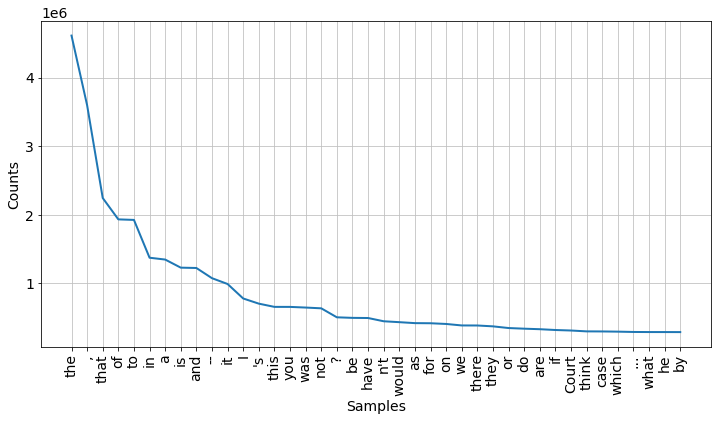

In [18]:
figure(num=None, figsize=(12, 6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

fdist.plot(40,cumulative=False)
plt.show()

In [19]:
'''Let's remove stopwords and punctuation'''
stop_words=set(stopwords.words("english"))
filtered_words=[]
for w in lower_words:
    if w.isalnum():
        if w not in stop_words:
            filtered_words.append(w)
filtered_words[:5]

['wish', 'delay', 'reading', 'part', 'decision']

In [20]:
'''A lemma is a form of a word that appears as an entry in a dictionary and is used to represent all the other possible forms 
(from Cambridge Dictionary)'''

final_words = []
lem = WordNetLemmatizer()
for word in filtered_words:
    final_words.append(lem.lemmatize(word,"v"))
final_words[:5]

['wish', 'delay', 'read', 'part', 'decision']

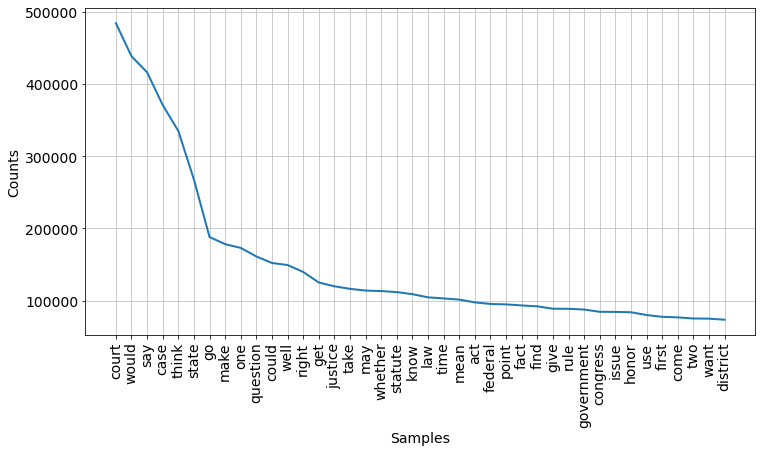

In [21]:
fdist = FreqDist(final_words)
figure(num=None, figsize=(12, 6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

fdist.plot(40,cumulative=False)
plt.show()

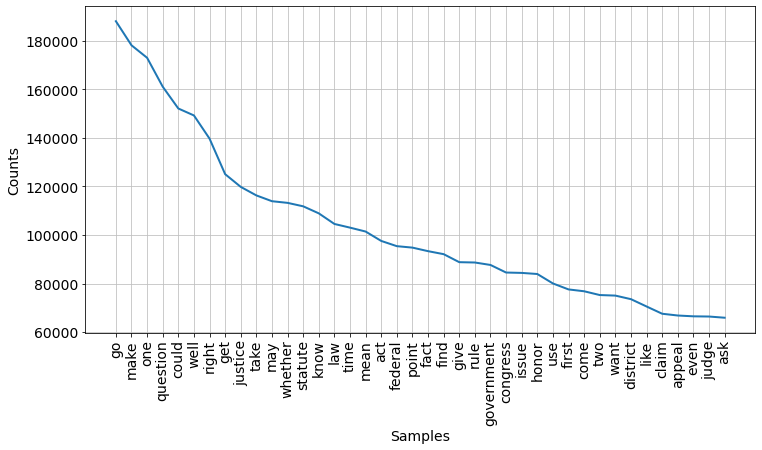

In [22]:
'''Can add the most common words as stop words. The word 'state' may be so common due to having 2 senses. It will be removed
in this analysis, but if anyone knows of a way to separate between the word's meanings that would be a cool thing to do '''

words =[]
stop_words1 = fdist.most_common(6)
top_6 = [stop_words1[i][0] for i,w in enumerate(stop_words1)]
for w in final_words:
    if w not in top_6:
        words.append(w)
        
fdist = FreqDist(words)
figure(num=None, figsize=(12, 6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

fdist.plot(40,cumulative=False)
plt.show()

In [23]:
'''Wordcloud takes in string types'''
final_str = ' '.join(words)

In [24]:
book_mask = np.array(Image.open("C:\\Users\\andre\\OneDrive\\Pictures\\book_mask.png"))

In [25]:
transformed_mask = np.ndarray((book_mask.shape[0],book_mask.shape[1]), np.int32)       

In [26]:
def transform_format(val):
    if val.any(0):
        return 255
    else:
        return val
    
transformed_mask = np.ndarray((book_mask.shape[0],book_mask.shape[1]), np.int32)

for i in range(len(book_mask)):
    transformed_mask[i] = list(map(transform_format, book_mask[i]))

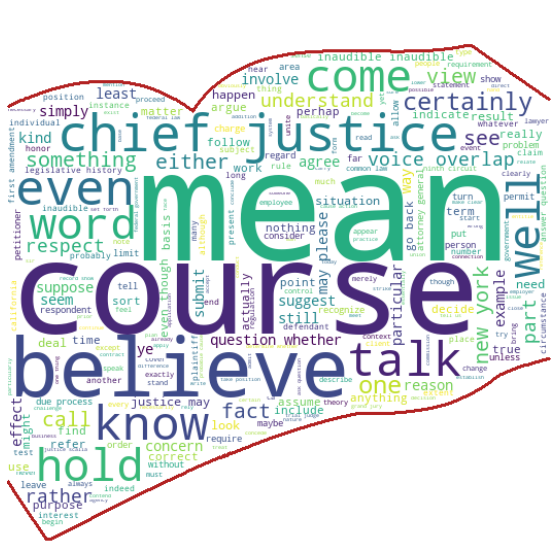

In [27]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=500, mask=book_mask,
                contour_width=3, contour_color='firebrick').generate(final_str)

# store to file
wc.to_file("words.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
with open('transcript.pkl', 'rb') as f:
    final_str = pickle.load(f)

In [29]:
with open('transcript.pkl', 'wb') as f:
    pickle.dump(final_str, f)